# Model training

## Import libraries

In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve, fbeta_score, make_scorer
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum
import numpy as np
import math

## Setup data

Load preprocessed dataset and create objects X and y to store the data and the target value. Then split data into training data and testing data.

In [9]:
# Load dataset
heart_dataset = pd.read_csv('./heart_dataset_preprocessed.csv')

# Split and reduce dataset (reduction only for test purposes)
X = heart_dataset.drop(columns='HeartDisease')
y = heart_dataset['HeartDisease']
X_train, _, y_train, _ = train_test_split(X, y, test_size = 0.95, random_state = 42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42, stratify=y_train)

## Methods

In [10]:
# Method that returns different scores for the passed parameters
def get_scores(y_test, y_predicted):
    digits = 4;
    scores = {
        'Accuracy': truncate(accuracy_score(y_test, y_predicted), digits),
        'Recall': truncate(recall_score(y_test, y_predicted), digits),
        'Precision': truncate(precision_score(y_test, y_predicted), digits),
        'F1 score': truncate(f1_score(y_test, y_predicted), digits),
        'F2 score': truncate(fbeta_score(y_test, y_predicted, beta=2), digits)
    }
    return scores

In [11]:
# Method that plots the ROC for the passed parameters
def plot_roc(title, ax, y_test, y_predicted):
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_predicted)
    ax.plot(false_positive_rate, true_positive_rate)
    ax.plot([0, 1], ls="--")
    ax.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    ax.set_title('Receiver Operating Characteristic (ROC) - '+title)
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

In [12]:
# Method that plots the feature importance for the passed parameters
def plot_feature_importance(title, ax, estimator):
    ax.set_title('Feature Importance for '+title)
    feat_importance = pd.Series(estimator.feature_importances_, index=X_train.columns)
    feat_importance.nlargest(12).plot(kind='barh', ax=ax)

In [13]:
# Method that plots the learning curve for the passed parameters
def plot_learning_curve(title, estimator, ax, X, y, cv, scoring):
    ax.set_title("Learning Curve: "+title)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=4,
        train_sizes=np.linspace(0.1, 1.0, 5),
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    ax.grid()
    ax.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    ax.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    ax.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")

In [27]:
# Method that prints a table of the passed scores
def print_scores(all_scores):
    header_row = "{header:<20}".format(header="Estimator")
    for score in list(all_scores.values())[0]:
        header_row+="{header:<15}".format(header=score)
    print(header_row)

    for estimator in all_scores.keys():
        current_row = "{estimator:<20}".format(estimator=estimator)
        estimator_scores = all_scores.get(estimator)
        for score in estimator_scores:
            score_value = get_nested(all_scores, estimator, score)
            current_row+="{score_value:<15}".format(score_value=score_value)
        print(current_row)

    print("\n")


In [15]:
# Method that prints the best parameters
def print_best_params(estimator_params):
    for estimator in estimator_params.keys():
        print("Best parameters for "+estimator+": ")
        parameters = estimator_params.get(estimator)
        for parameter in parameters:
            print(parameter+": "+str(get_nested(estimator_params, estimator, parameter)))
        print("\n")

In [16]:
# Helper method that returns the value of a nested dictionary
def get_nested(data, *args):
    if args and data:
        element  = args[0]
        if element:
            value = data.get(element)
            return value if len(args) == 1 else get_nested(value, *args[1:])

In [17]:
# Helper method that truncate scores to four decimals
def truncate(number, digits) -> float:
    nbDecimals = len(str(number).split('.')[1])
    if nbDecimals <= digits:
        return number
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper

## Baseline

We define a baseline model as a reference to the actual model with DummyClassifier from Scikit-Learn. Because our data is very imbalanced, we are using the stratified strategy.

Estimator           Accuracy       Recall         Precision      F1 score       F2 score       
Dummy Classifier    0.8439         0.0948         0.0938         0.0943         0.0946         




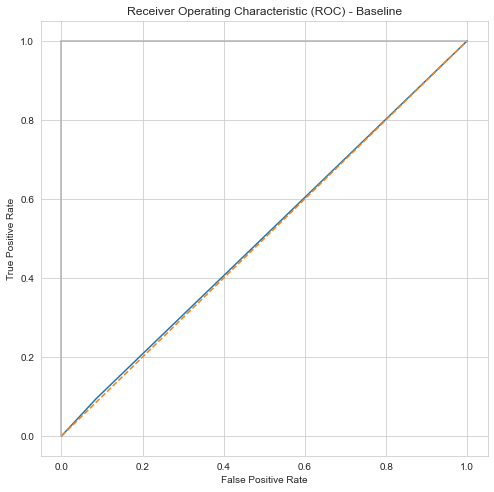

In [28]:
dummy_classifier = DummyClassifier(strategy='stratified')
dummy_classifier.fit(X_train, y_train)
y_predicted = dummy_classifier.predict(X_test)

print_scores({'Dummy Classifier':get_scores(y_test, y_predicted)})
plot_roc(title='Baseline', ax=plt.figure(figsize=(8, 8)).add_subplot(), y_test=y_test, y_predicted=y_predicted)
plt.show()

**Conclusion**

We achieve an 0.84 accuracy, a 0.09 recall, a 0.09 precision and a 0.09 F1-Score. Plotting the ROC curve shows that the baseline classifier is not really better than a random classifier


## Model selection

To find out which modeling method with which parameters best fits to our task, we define a set of modeling methods, train them with different parameters (hyperparameter tuning) and evaluate the results.

Estimator           Accuracy       Recall         Precision      F1 score       F2 score       
knn_estimator       0.904          0.1423         0.3513         0.2025         0.1615         
nn_estimator        0.9171         0.2481         0.5354         0.3391         0.278          
forest_estimator    0.8893         0.1605         0.2619         0.199          0.174          


Best parameters for knn_estimator: 
n_neighbors: 3


Best parameters for nn_estimator: 
activation: identity


Best parameters for forest_estimator: 
class_weight: {0: 1, 1: 1}
n_estimators: 3




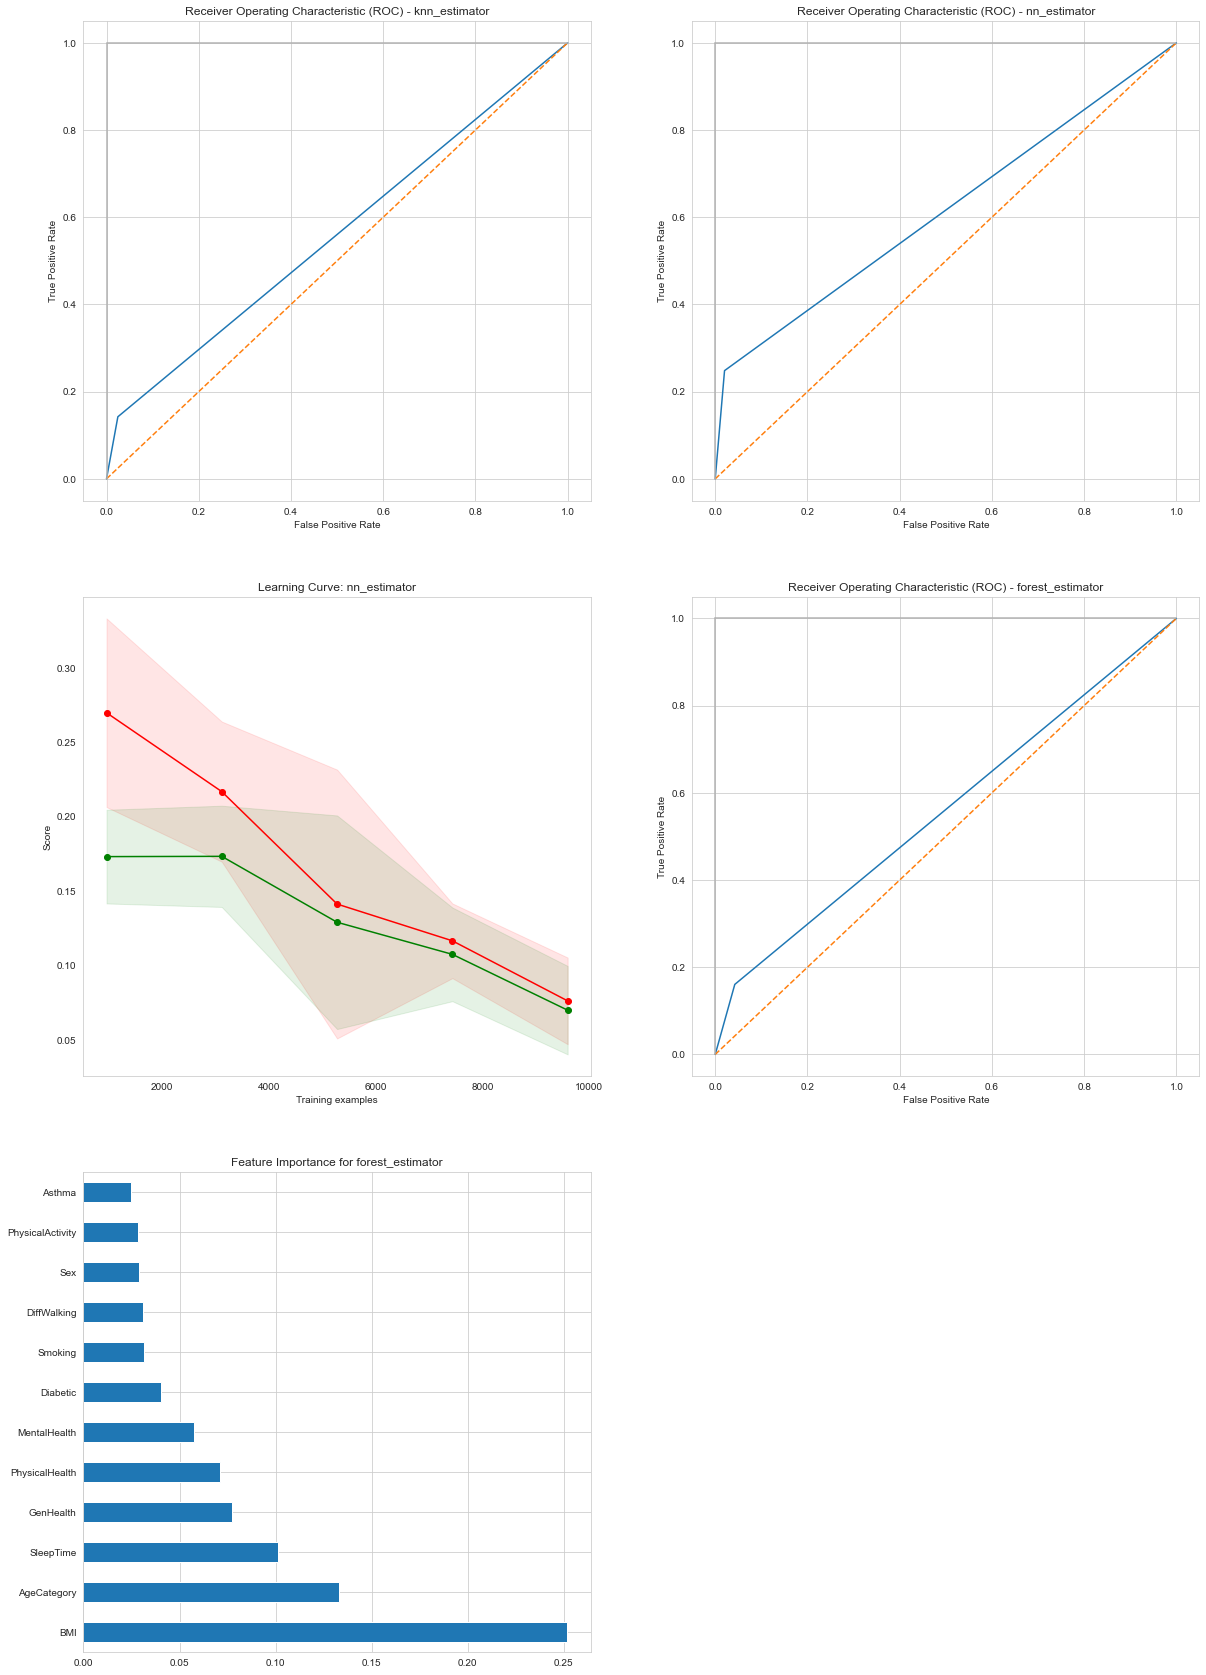

In [29]:
# Enumeration class containing all estimators we want to consider for classification
class Estimator(Enum):
    knn_estimator=KNeighborsClassifier()
    nn_estimator=MLPClassifier(random_state=1, max_iter=300)
    forest_estimator=RandomForestClassifier()
    # svc_estimator=SVC(random_state=0)

# TODO JG: Adjust nn parameters
# Dictionary of parameter grids of the estimators
param_grids = {
    Estimator.knn_estimator: {
        'n_neighbors': [2, 3, 5]
    },
    Estimator.forest_estimator: {
        'class_weight': [{0:1, 1:2}, {0:1, 1:1}],
        'n_estimators': [2, 3, 4, 5]
    },
    #Estimator.svc_estimator: {
    #    'kernel': ['linear', 'poly']
    #},
    Estimator.nn_estimator: {
        'activation': ['identity', 'logistic', 'tanh', 'relu']
    }
}

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
scoring = make_scorer(fbeta_score, beta=2)

all_scores = {}
best_params = {}

figure_roc = plt.figure(figsize=(20, 30))
figure_index = 1
number_of_rows = 3
number_of_columns = 2

for estimator in Estimator:
    # create the grid search instance
    grid_search_estimator = GridSearchCV(estimator=estimator.value,
                                         param_grid=param_grids.get(estimator),
                                         scoring= scoring,
                                         cv=cv,
                                         return_train_score=False,
                                         verbose=0
                                         )
    # training and prediction
    grid_search_estimator.fit(X_train, y_train)
    y_predicted = grid_search_estimator.predict(X_test)

    # evaluation of the model
    all_scores[estimator.name] = get_scores(y_test, y_predicted)
    best_params[estimator.name] = grid_search_estimator.best_params_

    ax = figure_roc.add_subplot(number_of_rows, number_of_columns, figure_index)
    plot_roc(title=estimator.name, ax=ax, y_test=y_test, y_predicted=y_predicted)
    figure_index += 1

    if estimator==Estimator.forest_estimator:
        ax = figure_roc.add_subplot(number_of_rows, number_of_columns, figure_index)
        plot_feature_importance(title=estimator.name, ax=ax, estimator=grid_search_estimator.best_estimator_)
        figure_index += 1

    if estimator==Estimator.nn_estimator:
        ax = figure_roc.add_subplot(number_of_rows, number_of_columns, figure_index)
        plot_learning_curve(title=estimator.name, estimator=estimator.value, ax=ax, X=X_train, y=y_train, cv=cv, scoring=scoring)
        figure_index += 1

print_scores(all_scores)
print_best_params(best_params)
plt.show()

**Conclusion**

TODO: Add conclusion